In [1]:
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Matlab to CSV

In [2]:
panasonic_data_path = '../../Panasonic Data/Panasonic 18650PF Data'
resample_1hz = True
vi_averages = True

def poptime(row):
   return row[0][0]

def convert_mat2csv(mat_file):
    mat_columns = ['TimeStamp', 'Voltage', 'Current', 'Ah', 'Wh', 'Power', 'Battery_Temp_degC', 'Time', 'Chamber_Temp_degC']
    mat_load = scipy.io.loadmat(mat_file)
    mat = mat_load['meas']  # mat_load has keys: Header, Global, Version and meas [which contains data]
    data = []
    for column in mat_columns:
        df = pd.DataFrame(mat[column][0, 0])
        df.rename(columns={0:column}, inplace=True)
        data.append(df)
    df = pd.concat(data, axis=1) 
    df['TimeStamp'] = df.apply(poptime, axis=1)  # (array([[array(['6/11/2017 8:22:53 PM'], dtype='<U20'), ...) format in mat file
    df.set_index('TimeStamp', inplace=True)
    df.to_csv(os.path.splitext(mat_file)[0]+'.csv')

In [3]:
count = 0
for folders in os.listdir(panasonic_data_path):
    level_1_d = os.path.join(panasonic_data_path, folders)
    sub_folders = os.listdir(level_1_d)           
    for folder in sub_folders:
        level_2_d = os.path.join(level_1_d, folder)
        if os.path.isdir(level_2_d): 
            for file in os.listdir(level_2_d):
                if file.endswith('.mat'):
                    count = count + 1
                    print(os.path.join(level_2_d, file))
                    convert_mat2csv(os.path.join(level_2_d, file))
        elif level_2_d.endswith('.mat'):
            count = count + 1
            print(level_2_d)
            convert_mat2csv(level_2_d)
print(count)

../../Panasonic Data/Panasonic 18650PF Data\-10degC\5 pulse test\06-07-17_12.29 n10degC_5pulse_HPPC_Pan18650PF.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\5 pulse test\06-07-17_14.11 3740_dis5_10p.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-07-17_08.40 3740_PreChg.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-08-17_10.21 3740_Charge1a.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-10-17_05.35 3740_Charge2a.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-10-17_09.26 3740_Pause1.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-10-17_13.07 3740_Charge1.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-10-17_16.36 3740_Pause2.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pauses\06-10-17_20.16 3740_Charge2.mat
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Charges and Pau

In [4]:
def panasonic_get_files(data_path, drive_cycle_files, temperature, get_trise_tests_only=False):
    
    panasonic_csv_files = []
    # Loop through each temperature folder in the data folder
    for temperature_folder in os.listdir(data_path):
        temperature_folder_path = os.path.join(data_path, temperature_folder)
        # Loop through each test folder in the temperature folder
        for cycle_test_folder in os.listdir(temperature_folder_path):
            cycle_test_folder_path = os.path.join(temperature_folder_path, cycle_test_folder)
            
            if (os.path.isdir(cycle_test_folder_path) and 
                'drive cycles' in cycle_test_folder_path.lower() and 
                not get_trise_tests_only):
                for file in os.listdir(cycle_test_folder_path):
                    if (file.endswith('.csv') and
                        any(substring in file for substring in drive_cycle_files) and
                        any(substring in temperature_folder_path for substring in temperature)
                        ):
                            file_path = os.path.join(cycle_test_folder_path, file)
                            panasonic_csv_files.append(file_path)
            # 'Trise' folder
            elif get_trise_tests_only:
                print("false")
                file = cycle_test_folder_path
                if (file.endswith('.csv') and 
                    any(substring in file for substring in drive_cycle_files) and 
                    any('/'+ substring in temperature_folder_path for substring in temperature)):
                        file_path = os.path.join(cycle_test_folder_path, file)
                        panasonic_csv_files.append(file_path)
    print(len(panasonic_csv_files))
    return list(panasonic_csv_files)

In [5]:
panasonic_test_temps = ['n10degC', '0degC', '10degC', '25degC'] # can add n20degC
panasonic_test_discharge_cycles = ['LA92', 'NN'] # LA92 is urban driving simulation with more frequent stops, NN is a custom drive cyle of combination of LA92 and US06

panasonic_train_temps = ['n10degC', '0degC', '10degC', '25degC']
panasonic_train_discharge_cycles = ['Cycle_1', 'Cycle_2', 'Cycle_3', 'Cycle_4', 'US06']   # Excluded UDDS and HWFET, US06 means aggresive driving cycle

panasonic_train_files = panasonic_get_files(panasonic_data_path,
                                                  panasonic_train_discharge_cycles, 
                                                  panasonic_train_temps)

panasonic_test_files = panasonic_get_files(panasonic_data_path, 
                                                 panasonic_test_discharge_cycles,
                                                 panasonic_test_temps)

for file in panasonic_train_files:
    if "UDDS_LA92" in file or "LA92_NN" in file:
        panasonic_train_files.remove(file)

for file in panasonic_test_files:
    if "UDDS_LA92" in file or "LA92_NN" in file:
        panasonic_test_files.remove(file)

# Delete duplicate timestamps from data
panasonic_train_files[0]

27
14


'../../Panasonic Data/Panasonic 18650PF Data\\-10degC\\Drive Cycles\\06-07-17_08.39 n10degC_US06_Pan18650PF.csv'

### Data Pre-processing

In [6]:
def normalization(dataset, minmax_norm):
    # scale (normalize) the dataset 
    # min max normalization
    if(minmax_norm):
        dataset_norm = (dataset - dataset.min())/(dataset.max() - dataset.min())
    # mean normalization
    else:
        dataset_norm = (dataset - dataset.mean())/dataset.std()
        
    return dataset_norm

def panasonic_create_dataset(file_paths, drive_cycle_files, vi_averages = True, resample_1hz = True, minmax_norm = True):
    merged = pd.DataFrame()
    for path in file_paths:
        cycle = pd.read_csv(path, index_col=0)
        print(path + " " + str(cycle.shape[0]))
        
        cycle.rename(columns={"Battery_Temp_degC":"Temperature", "Ah":"Capacity"}, inplace=True)  
        #print(cycle['Time'].unique())
        cycle['Time'] = pd.to_datetime(cycle['Time'])  # Convert 'Time' column to datetime
        cycle.set_index('Time', inplace=True)
        if resample_1hz:
            # cycle = cycle.resample('1S').first()  # ensures that only the first value in each second window is kept  [Paper logic but it return sonly first row of every timestamp]      
            cycle = cycle[~cycle.index.duplicated(keep='first')]  # Retain the first occurrence of each timestamp  -- Our logic
            
        # Discharge cycles have capcity values <= 0
        # Charge cycles have capcity values > 0
        # Filtering Discharge Cycles
        cycle = cycle[(cycle['Capacity'] <= 0)]
        
        max_discharge = abs(min(cycle['Capacity']))
        cycle['Capacity'] = (cycle['Capacity'] + max_discharge)/max_discharge  #Scaling it between 0 and 1
        
        # calculate 'Power'
        cycle['Power'] = cycle['Voltage'] * cycle['Current']

        # select required features
        parameters = cycle[['Voltage', 'Current', 'Temperature', 'Power', 'Capacity']].copy()

        # calculate 'Voltage', 'Current' and 'Power' averages
        # 500 second rolling window which translates to rougly 500 data points for resampled data [non-deuplicate] and 5000 for raw data
        rolling_window = 5000
        if vi_averages and resample_1hz:
            rolling_window = int(rolling_window / 10)

        if vi_averages:
            parameters['Voltage Average'] = parameters['Voltage'].rolling(rolling_window).mean()
            parameters['Current Average'] = parameters['Current'].rolling(rolling_window).mean()
            parameters['Power Average'] = parameters['Power'].rolling(rolling_window).mean()
        
        # drop rows with NaN or empty values in them, reset the index to reflect
        parameters.dropna(inplace=True)
        parameters.reset_index(drop=True, inplace=True)
      
        try:
            merged = pd.concat([merged, parameters], ignore_index=True)
        except:
            merged = parameters.copy()
            
    merged_norm = normalization(merged, minmax_norm)
    print(merged.shape)
        
    return merged, merged_norm

In [7]:
panasonic_train, panasonic_train_norm = panasonic_create_dataset(panasonic_train_files,
                                                                       panasonic_train_discharge_cycles, 
                                                                       vi_averages, 
                                                                       resample_1hz)

panasonic_test, panasonic_test_norm = panasonic_create_dataset(panasonic_test_files, 
                                                                   panasonic_test_discharge_cycles, 
                                                                   vi_averages, 
                                                                   resample_1hz)

../../Panasonic Data/Panasonic 18650PF Data\-10degC\Drive Cycles\06-07-17_08.39 n10degC_US06_Pan18650PF.csv 31197
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Drive Cycles\06-10-17_11.25 n10degC_Cycle_1_Pan18650PF.csv 60234
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Drive Cycles\06-10-17_18.35 n10degC_Cycle_2_Pan18650PF.csv 59712
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Drive Cycles\06-11-17_01.39 n10degC_Cycle_3_Pan18650PF.csv 56857
../../Panasonic Data/Panasonic 18650PF Data\-10degC\Drive Cycles\06-11-17_08.42 n10degC_Cycle_4_Pan18650PF.csv 61102
../../Panasonic Data/Panasonic 18650PF Data\-20degC\Drive cycles\06-24-17_04.29 n20degC_Cycle_1_Pan18650PF.csv 50712
../../Panasonic Data/Panasonic 18650PF Data\-20degC\Drive cycles\06-24-17_11.58 n20degC_Cycle_2_Pan18650PF.csv 50375
../../Panasonic Data/Panasonic 18650PF Data\-20degC\Drive cycles\06-24-17_19.29 n20degC_Cycle_3_Pan18650PF.csv 50147
../../Panasonic Data/Panasonic 18650PF Data\-20degC\Drive cycles\06

In [8]:
panasonic_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Voltage,163184.0,3.555996,0.295182,2.468590,3.396330,3.574540,3.764330,4.212940
Current,163184.0,-1.117677,2.057242,-21.061440,-1.920690,-0.520190,-0.011430,9.878360
Temperature,163184.0,9.311816,14.031833,-18.834099,-1.147187,11.404679,26.045400,32.770330
Power,163184.0,-3.721848,6.911007,-53.440156,-6.644923,-1.860093,-0.041102,36.371348
Capacity,163184.0,0.454234,0.279444,0.000000,0.213792,0.461859,0.702808,0.965059
Voltage Average,163184.0,3.576905,0.261269,2.577134,3.412256,3.588041,3.768280,4.097724
Current Average,163184.0,-1.163439,0.638378,-3.081631,-1.553321,-1.003507,-0.672662,-0.073155
Power Average,163184.0,-3.897989,2.054264,-9.172038,-5.174242,-3.379576,-2.322495,-0.186198


In [9]:
panasonic_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Voltage,81680.0,3.606144,0.264231,2.455730,3.440720,3.609280,3.798430,4.211000
Current,81680.0,-0.911485,2.109359,-15.303460,-1.721430,-0.182920,-0.003270,9.398170
Temperature,81680.0,10.052699,13.795045,-16.924893,-0.728340,12.250153,26.258360,29.811360
Power,81680.0,-3.016618,7.188578,-38.779832,-6.185022,-0.678030,-0.012320,35.077695
Capacity,81680.0,0.468976,0.281569,0.000000,0.223030,0.473727,0.716463,0.963742
Voltage Average,81680.0,3.623645,0.225842,3.112091,3.456356,3.615938,3.795893,4.101572
Current Average,81680.0,-0.935655,0.319005,-1.774341,-1.164852,-0.862747,-0.736887,-0.240791
Power Average,81680.0,-3.110684,0.973514,-5.254689,-3.907860,-2.914647,-2.550117,-0.701539


In [10]:
panasonic_train.head()

,Voltage,Current,Temperature,Power,Capacity,Voltage Average,Current Average,Power Average
0,3.59320,-2.76099,-1.362276,-9.920789,0.859221,3.773691,-2.067111,-7.027305
1,3.44908,-4.89400,-1.350954,-16.879798,0.858585,3.772223,-2.076900,-7.061065
2,3.48511,-4.24479,-1.362276,-14.793560,0.857994,3.770830,-2.085389,-7.090652
3,3.52950,-3.57026,-1.362276,-12.601233,0.857492,3.769526,-2.092530,-7.115854
4,3.50313,-3.95571,-1.362276,-13.857366,0.856955,3.768170,-2.100441,-7.143569


In [11]:
panasonic_train_norm.head()

,Voltage,Current,Temperature,Power,Capacity,Voltage Average,Current Average,Power Average
0,0.644716,0.591486,0.338572,0.484563,0.890330,0.786903,0.337220,0.238679
1,0.562095,0.522545,0.338792,0.407079,0.889671,0.785938,0.333967,0.234922
2,0.582750,0.543528,0.338572,0.430308,0.889059,0.785021,0.331145,0.231630
3,0.608198,0.565329,0.338572,0.454718,0.888538,0.784164,0.328772,0.228825
4,0.593081,0.552871,0.338572,0.440732,0.887982,0.783273,0.326142,0.225741


In [12]:
print("Training Dimensions: ",panasonic_train.shape)
print("Testign Dimensions: ",panasonic_test.shape)

Training Dimensions:  (163184, 8)
Testign Dimensions:  (81680, 8)


### Plots

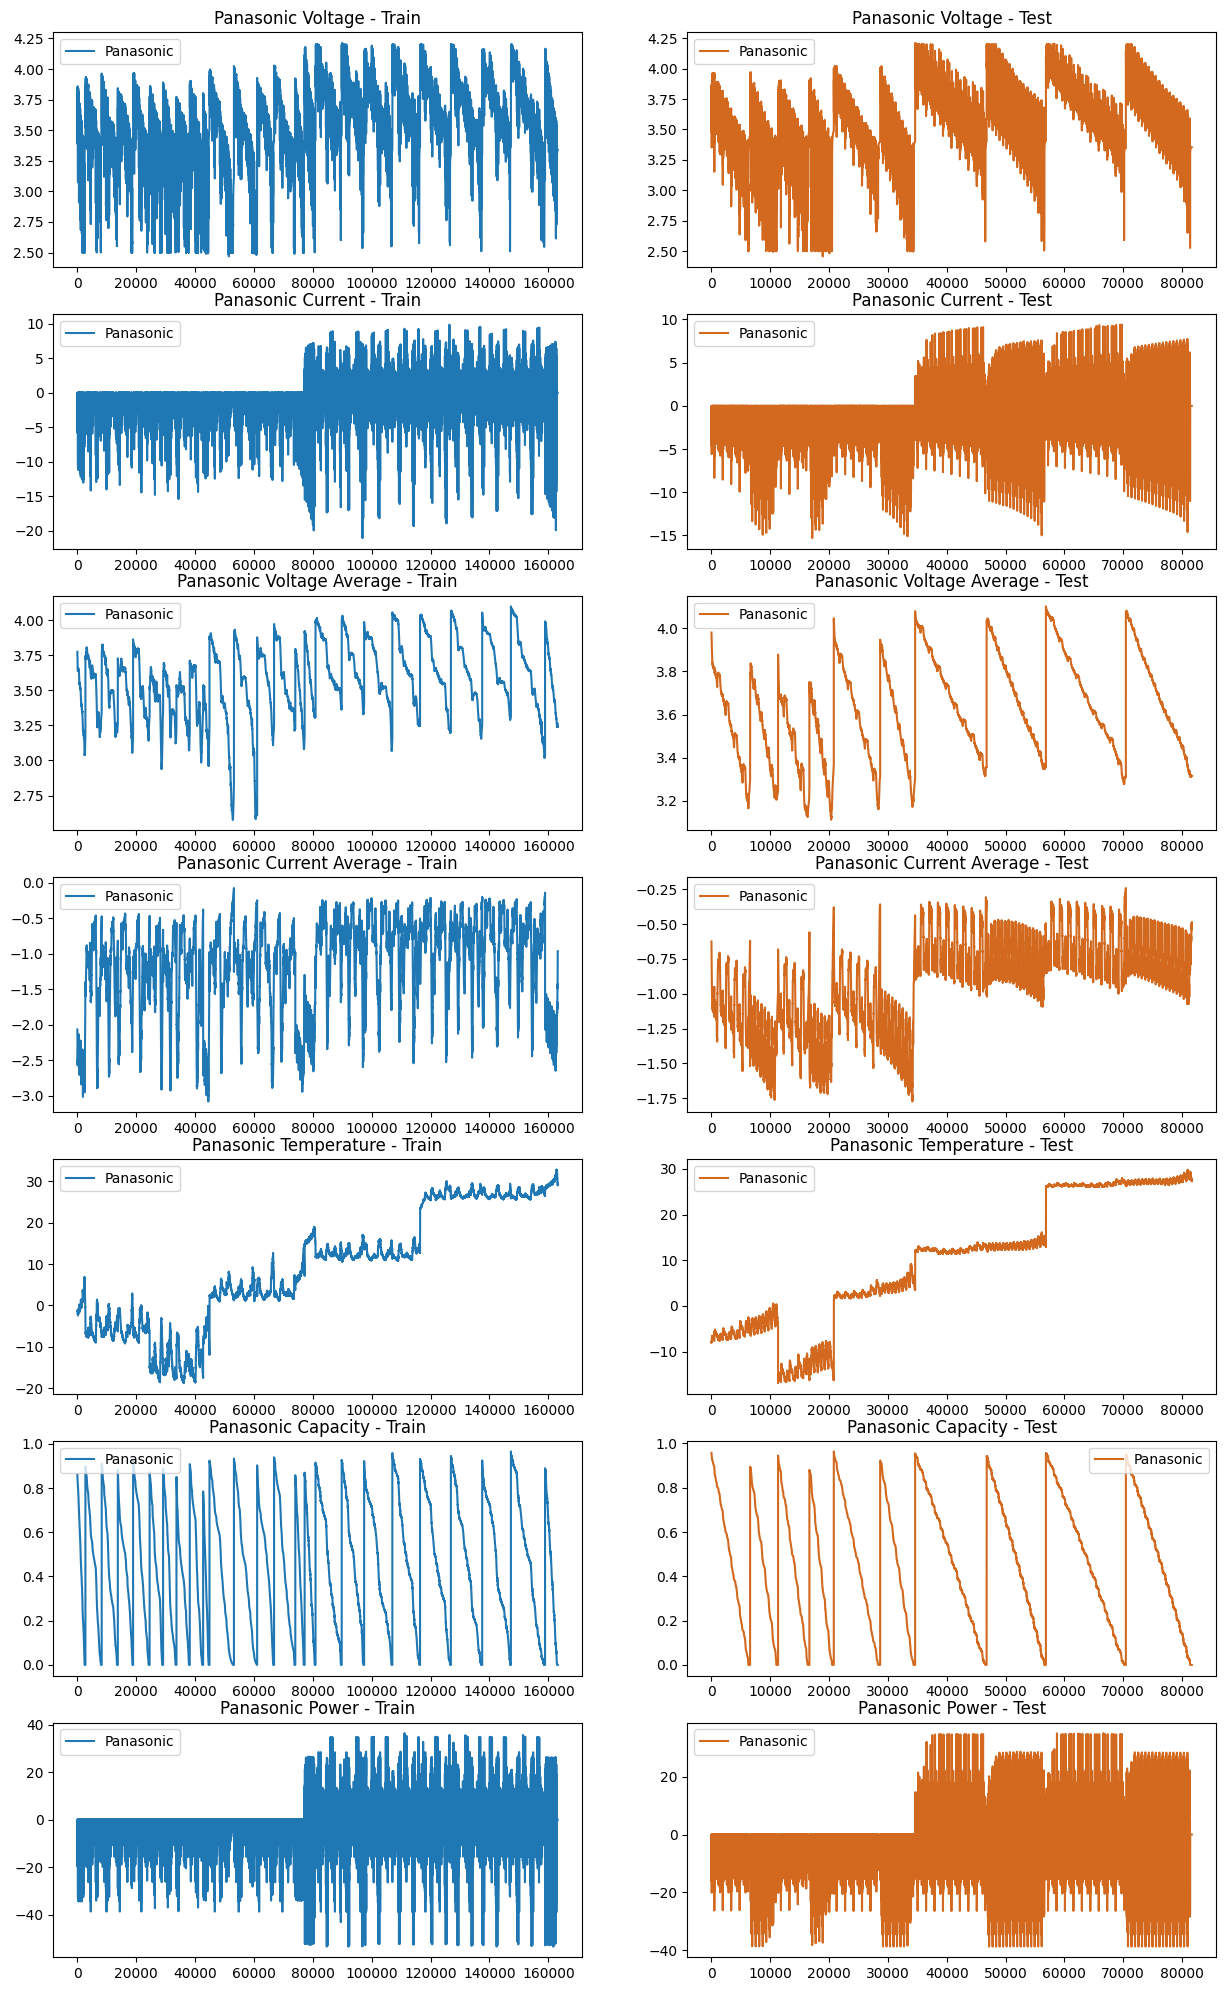

In [13]:
plot_cols = ['Voltage', 'Current', 'Voltage Average', 'Current Average', 'Temperature', 'Capacity', 'Power']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=2, figsize=(15, 25))

for i, col in enumerate(plot_cols):
    axs[i, 0].plot(panasonic_train[col], label='Panasonic')
    axs[i, 0].set_title(f'Panasonic {col} - Train')
    axs[i, 0].legend()
    
    axs[i, 1].plot(panasonic_test[col], label='Panasonic', color="chocolate")
    axs[i, 1].set_title(f'Panasonic {col} - Test')
    axs[i, 1].legend()

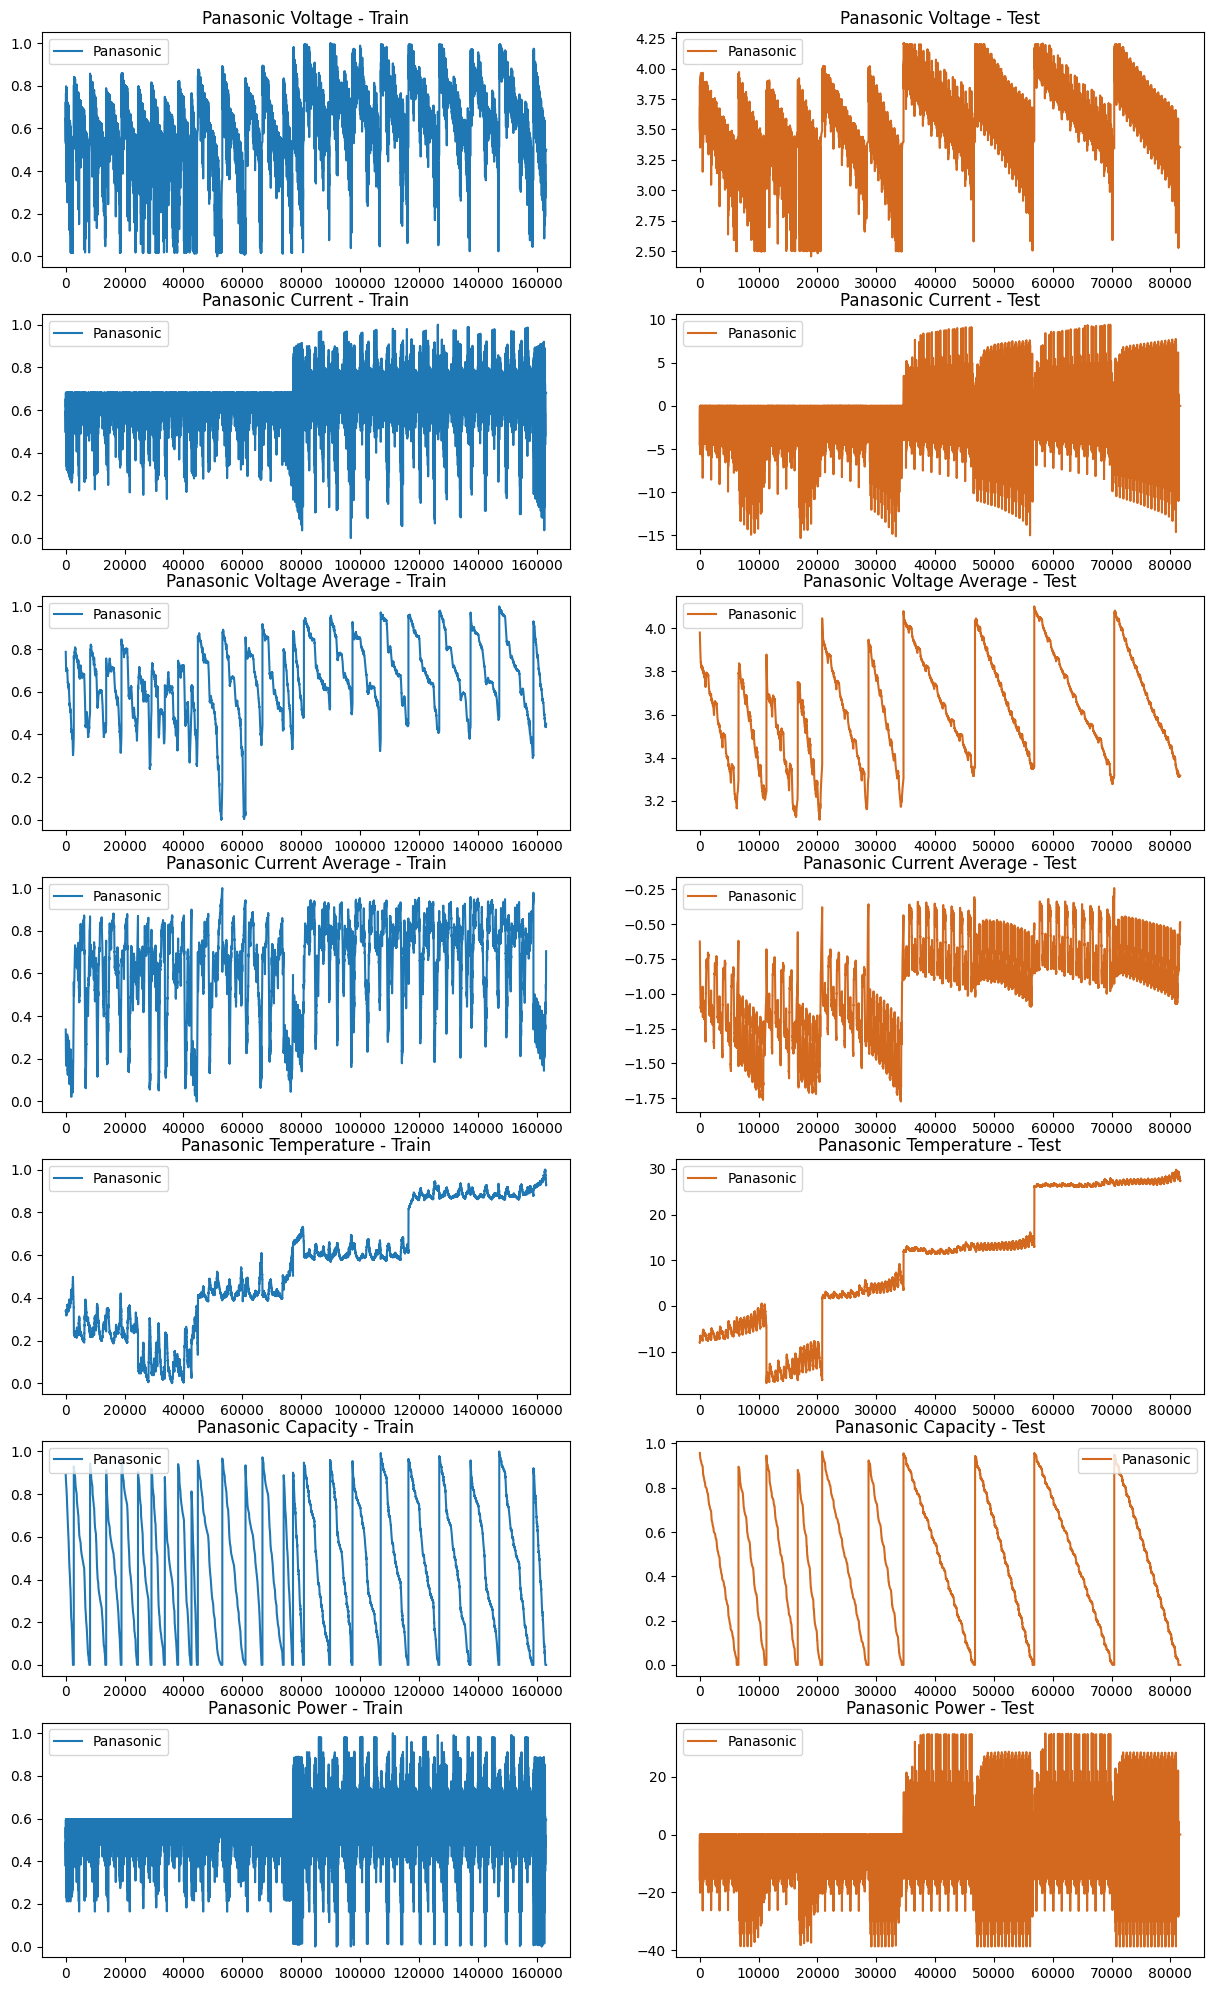

In [14]:
plot_cols = ['Voltage', 'Current', 'Voltage Average', 'Current Average', 'Temperature', 'Capacity', 'Power']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=2, figsize=(15, 25))

for i, col in enumerate(plot_cols):
    axs[i, 0].plot(panasonic_train_norm[col], label='Panasonic')
    axs[i, 0].set_title(f'Panasonic {col} - Train')
    axs[i, 0].legend()
    
    axs[i, 1].plot(panasonic_test[col], label='Panasonic', color="chocolate")
    axs[i, 1].set_title(f'Panasonic {col} - Test')
    axs[i, 1].legend()

In [15]:
# # Saving normalized dataframes into csv for training
# panasonic_train_norm.to_csv('Panasonic_Training_Normalized.csv')
# panasonic_test_norm.to_csv('Panasonic_Testing_Normalized.csv')
# panasonic_train.to_csv('Panasonic_Training.csv')
# panasonic_test.to_csv('Panasonic_Testing.csv')